### 9.3. Dimensionality Reduction and Classification on Engineered Data

In this section we'll focus on `t-SNE` and `UMAP`.  

1. Apply Dimensionality Reduction  
   Apply `t-SNE` and / or `UMAP` on the engineered data.  
   Make sure to use the appropriate options to utilize the metric.  
   Apply this on the whole data.
2. Apply Classification  
   Apply a classifier (From SciKit Learn without Neural Based) on the low dimensional data.
3. Measure Performance of the Classifier
   Apply leave one out cross validation with score based on accuracy.  
   You should use [`cross_val_predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html).  
   This will generate a vector of 287 predictions.
4. Display Results  
   Display the confusion matrix and the total accuracy.

**This is a competition**:

 * The group with the 1st highest score will get 4 bonus points.
 * The group with the 2nd highest score will get 2 bonus points.


![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 004 - Part IV

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 17/06/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_03/Exercise0004Part004.ipynb)

In [ ]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, TSNE
from sklearn.metrics import pairwise_distances
from umap import UMAP
from scipy.linalg import eigvalsh
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# Computer Vision

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [ ]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [ ]:
# Constants

DATA_FILE_URL   = r'https://drive.google.com/uc?export=download&confirm=9iBg&id=1UXLdZgXwClgwZVszRq88UaaN2nvgMFiC'
DATA_FILE_NAME  = r'BciData.npz'


In [ ]:
# Auxiliary Functions

def Plot2DScatter(mX: np.ndarray, hA: plt.Axes, vC: np.ndarray = None, label:np.ndarray = None) -> None:
    m = mX.min()
    M = mX.max()
    if vC is not None:
        scatter = hA.scatter(*mX.T, s = 50,  c = vC, edgecolor = 'k', alpha = 1, label=label)
    else:
        scatter = hA.scatter(*mX.T, s = 50,  c = 'lime', edgecolor = 'k', alpha = 1,label=label)
    hA.set_xlim([m, M])
    hA.set_ylim([m, M])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')
    return scatter

def PlotLabelsHistogram(vY: np.ndarray, hA = None, lClass = None, xLabelRot: int = None) -> plt.Axes:

    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))

    vLabels, vCounts = np.unique(vY, return_counts = True)

    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_ylabel('Number of Samples')
    hA.set_xticks(vLabels)
    if lClass is not None:
        hA.set_xticklabels(lClass)

    if xLabelRot is not None:
        for xLabel in hA.get_xticklabels():
            xLabel.set_rotation(xLabelRot)

    return hA


## Guidelines

 - Fill the full names and ID's of the team members in the `Team Members` section.
 - Answer all questions / tasks within the Jupyter Notebook.
 - Use MarkDown + MathJaX + Code to answer.
 - Verify the rendering on VS Code.
 - Submission in groups (Single submission per group).
 - You may and _should_ use the forums for questions.
 - Good Luck!

* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.
* <font color='brown'>(**#**)</font> The total run time of this notebook must be **lower than 90 [Sec]**.

## Generate / Load Data

In [ ]:
# Download Data
# This section downloads data from the given URL if needed.

if (DATA_FILE_NAME != 'None') and (not os.path.exists(DATA_FILE_NAME)):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 9. T-SNE and UMAP

In this section we'll use the _t-SNE_ and _UMAP_ algorithms to analyze EEG Signals in teh context of _Brain Computer Interface_ (BCI).  

### The BCI Data Set

The Brain Computer Interfaces (BCI) Data from [BCI Competition IV](https://www.bbci.de/competition/iv/).  
Specifically we'll use [data set 2a](https://www.bbci.de/competition/iv/#dataset2a) provided by the Institute for Knowledge Discovery (Laboratory of Brain Computer Interfaces), Graz University of Technology, (Clemens Brunner, Robert Leeb, Gernot Müller-Putz, Alois Schlögl, Gert Pfurtscheller).  
This is a recording of EEG signals while the subject is doing a cued movement of the left hand, right hand, feet or tongue.

The data is composed of:

 * 22 EEG channels (0.5-100Hz; notch filtered).
 * Sampling Rate of 250 [Hz] for 4 [Sec] for total of 1000 samples.
 * 4 classes: _left hand_, _right hand_, _feet_, _tongue_.
 * 9 subjects.
 * 287 measurements.

</br>

* <font color='brown'>(**#**)</font> You should install [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) on your system.

In [ ]:
# Generate Data

dData = np.load(DATA_FILE_NAME)
mX    = dData['mX1']
vY    = dData['vY1']

# Sample: An observation of a subject.
# Measurement: Sample in time of the EEG signal.
# Channel: EEG Channel.
numSamples, numMeasurements, numChannels = mX.shape
lLabel = ['Left Hand', 'Right Hand', 'Foot', 'Tongue'] #<! The labels

print(f'The data shape: {mX.shape}')
print(f'The number of samples: {mX.shape[0]}')
print(f'The number of measurements per sample: {mX.shape[1]}')
print(f'The number of EEG channels: {mX.shape[2]}')
print(f'The classes labels: {np.unique(vY)}')

The data shape: (287, 1000, 22)
The number of samples: 287
The number of measurements per sample: 1000
The number of EEG channels: 22
The classes labels: [0 1 2 3]


* <font color='brown'>(**#**)</font> In the above `sample` is used per object detected.
* <font color='brown'>(**#**)</font> In the above `measurement` is used to describe the time sample (Like in Signal Processing).

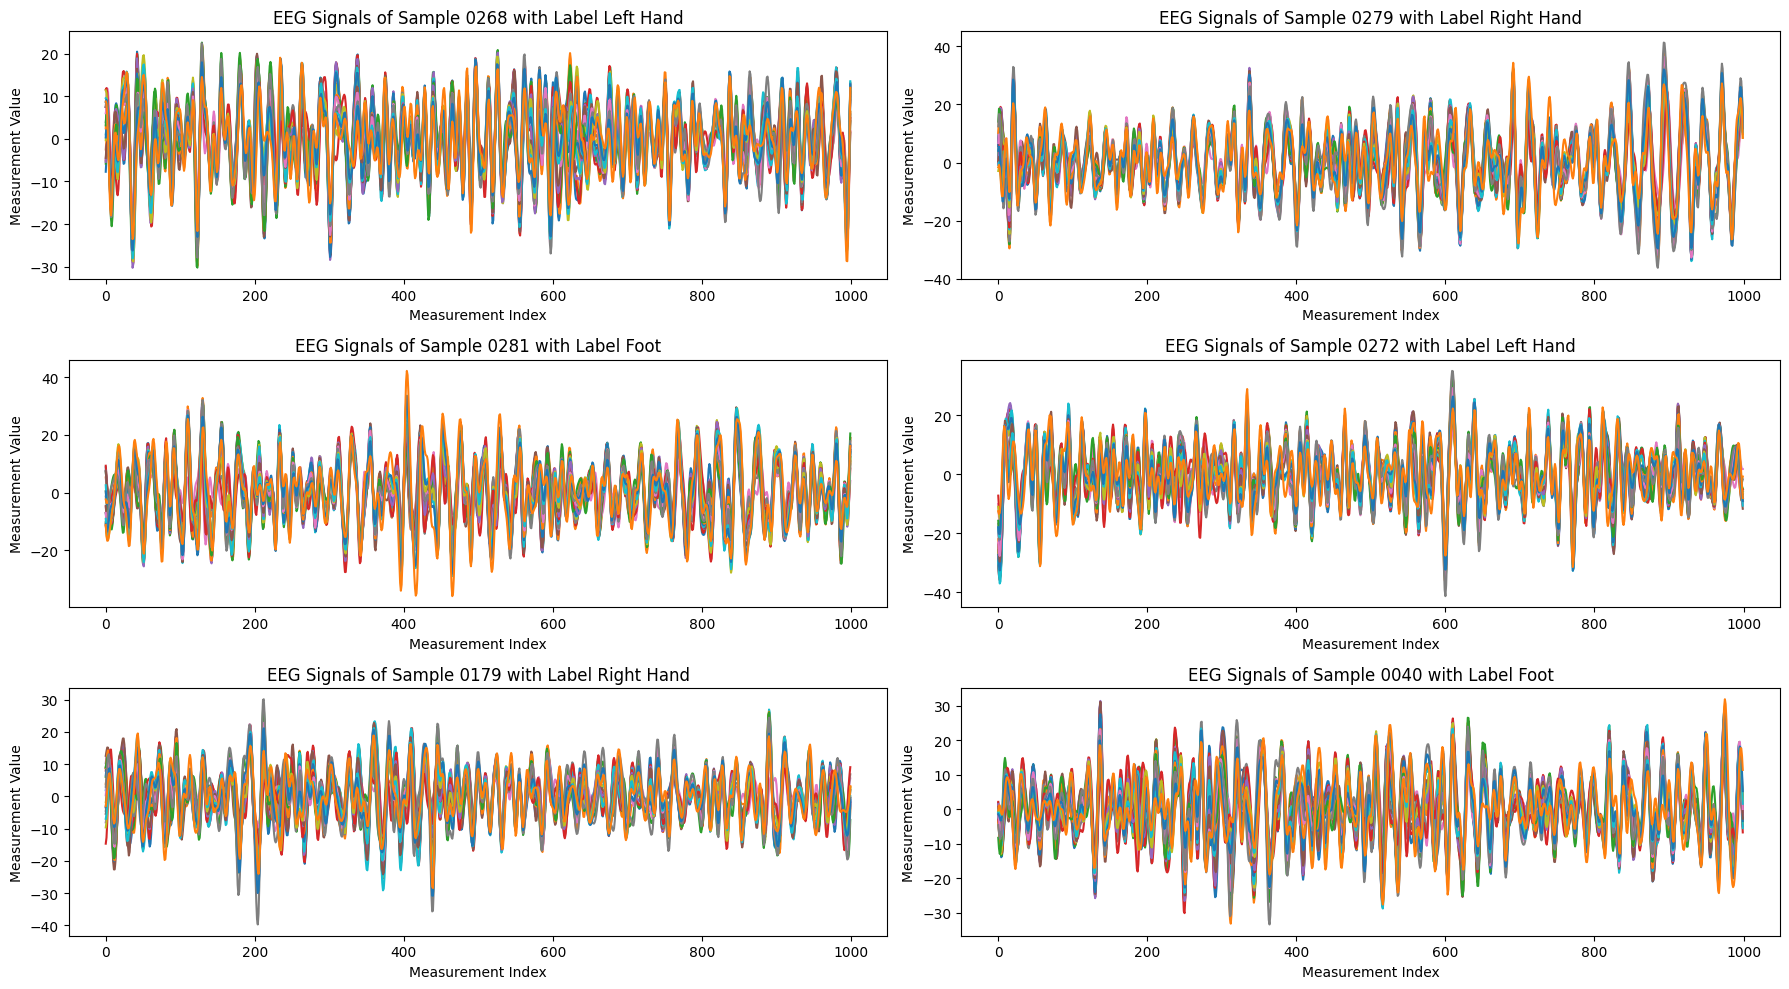

In [ ]:
# Plot the Data

numRowsPlot = 3
numColsPlot = 2

numPlots = numRowsPlot * numColsPlot

hF, hAs = plt.subplots(nrows = numRowsPlot, ncols = numColsPlot, figsize = (18, 10))
hAs = hAs.flat

vIdx = np.random.choice(numSamples, numPlots, replace = False)

for sampleIdx, hA in zip(vIdx, hAs):
    mXX = mX[sampleIdx, :, :]
    hA.plot(mXX)
    hA.set_title(f'EEG Signals of Sample {sampleIdx:04d} with Label {lLabel[vY[sampleIdx]]}')
    hA.set_xlabel('Measurement Index')
    hA.set_ylabel('Measurement Value')

hF.tight_layout()

plt.show()

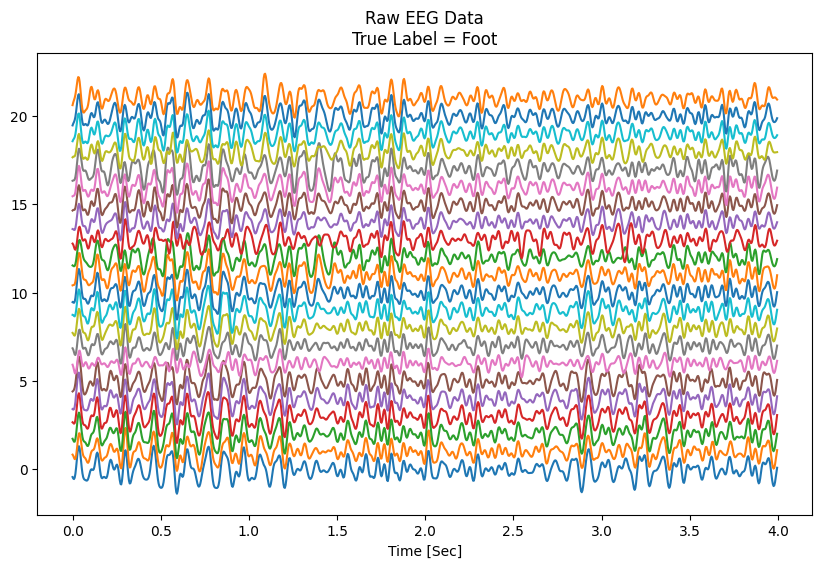

In [ ]:
# Plot the Data
# Show a shifted and scaled channels at a single plot.
# You may run it several times to observe different measurements.

numSamples, numMeasurements, numChannels = mX.shape #<! Samples, Time Samples, Channels
idx     = np.random.randint(numSamples)
mXi     = mX[idx, :, :].copy()
yi      = vY[idx]

# Normalizing and Vertically Shifting
mXi -= mXi.mean(0)
mXi /= 20
mXi += np.arange(numChannels)[None, :]
vT   = np.linspace(0, 4, numMeasurements, endpoint = False)

hF, hA = plt.subplots(figsize = (10, 6))
hA.plot(vT, mXi)
hA.set_title (f'Raw EEG Data\nTrue Label = {lLabel[yi]}')
hA.set_xlabel('Time [Sec]')

plt.show()

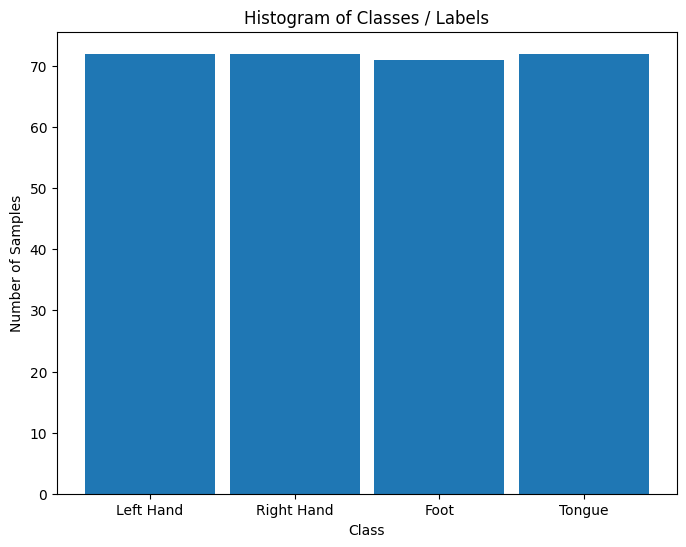

In [ ]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = lLabel)

* <font color='brown'>(**#**)</font> The data is balanced.

### 9.1. Processing RAW Data

In this section we'll compare 4 dimensionality reduction methods:

 - IsoMap.
 - MDS.
 - t-SNE.
 - UMAP.

We'll reduce the data dimension to `d = 2` and use the reference labels to display result.

The steps:

1. Data Pre Processing  
     * Reshape data into `mXRaw` such that each measurement is a row.  
       Namely the data should have dimensions of `287 x 22_000`.  
     * Apply dimensionality reduction using PCA to keep most of the data energy.
2. Set Parameters  
   Set parameters of each method to get results.  
   Set the amount of energy preserved using the PCA pre processing.
   **No need for grid search, just try and error of few values**.
3. Apply the Transform  
   Apply the transform on the data.  
   The low dimensional data should be in 2D space.  
4. Display Results  
   Create a subplot per method showing teh results and the used parameters.  

* <font color='brown'>(**#**)</font> No need to self implement any of the methods.

In [ ]:
#===========================Fill This===========================#
# 1. Pre Process data:
#    * Reshape to (287 x 22_000).
#    * Apply PCA to preserve `relEnergy` of the energy.
# 2. Apply Dimensionality Reduction (d = 2) using IsoMap, MDS, t-SNE and UMAP.
#    Choose a reasonable parameters for each.
# 3. Display the Low Dimensionality data.
#    Include the parameters in the title of each method.
# !! The output should be a figure of 1x4 axes (2D Scatter and 3D Scatter per method).
# !! You may use `Plot2DScatter()` for displaying the the data.

d= 2
mX_reshaped = mX.reshape(mX.shape[0],-1)
relEnergy = 0.97
pca = PCA(n_components=relEnergy, svd_solver='full')
mX_reduced = pca.fit_transform(mX_reshaped)
models = {"isomap": Isomap, "T-SNE": TSNE, "UMAP": UMAP, "MDS": MDS}
models_params = {"isomap" : {"n_neighbors":3, "n_components":d},
          "T-SNE" : {"n_components":d, "perplexity":20},
          "UMAP" : {"n_neighbors":15, "n_components":d},
          "MDS" : {"n_components":d}}



#===============================================================#

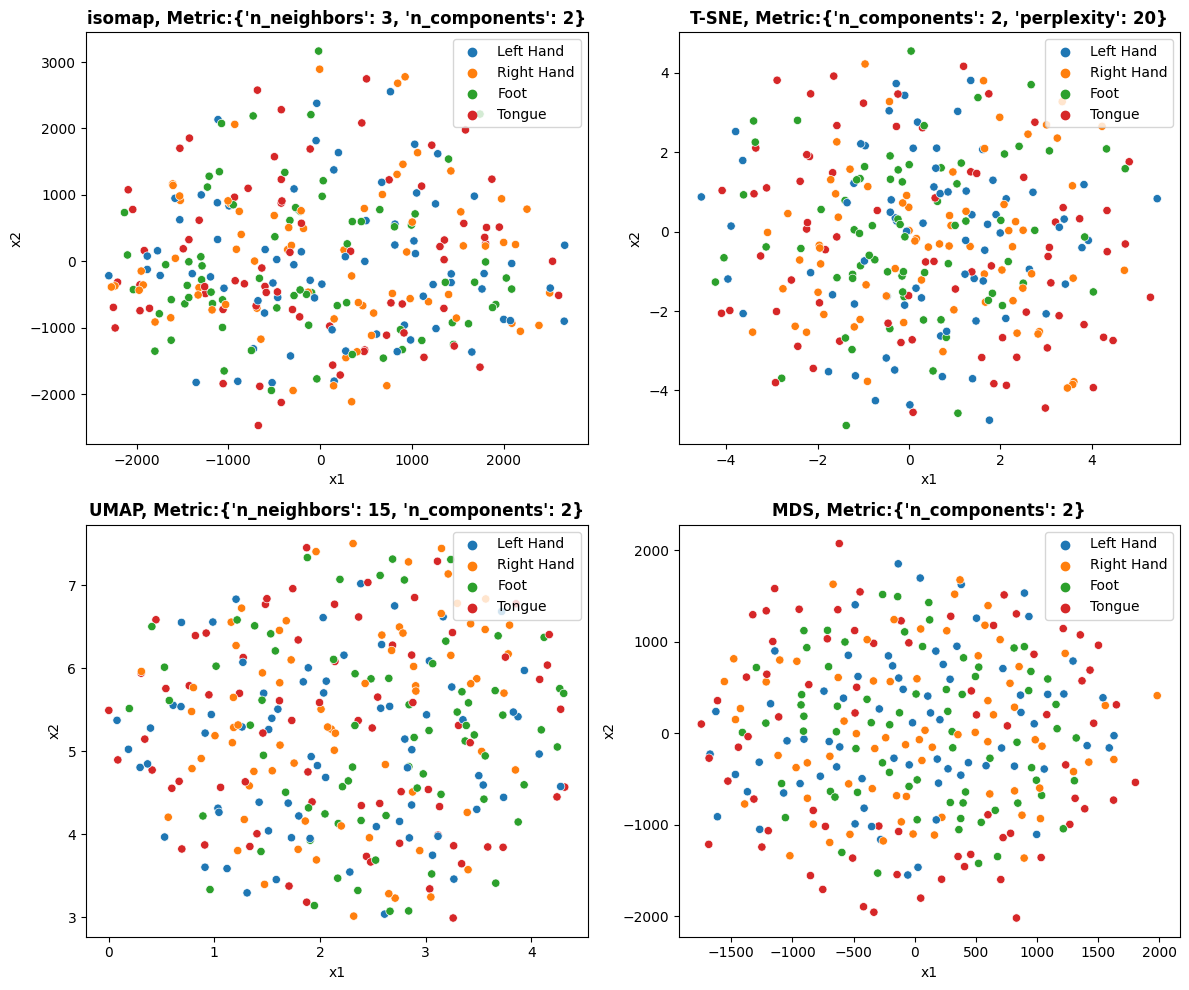

In [ ]:
def f(x):
    return lLabel[x]
df = pd.DataFrame({"x1":np.zeros(mX_reduced.shape[0]), "x2":np.zeros(mX_reduced.shape[0]), "label":vY})
df["Class"] = df["label"].map(f)
fig, axes = plt.subplots(2, 2 , figsize = (12, 10))
for ax, (model_name, model) in zip(axes.flatten(), models.items()):
    m = model(**models_params[model_name])
    transformed = m.fit_transform(mX_reduced)
    df['x1'] = transformed[:,0]
    df['x2'] = transformed[:,1]
    sns.scatterplot(x='x1', y='x2', data=df, hue="Class", ax=ax)
    ax.set_title(f'{model_name}, Metric:{models_params[model_name]}', fontweight="bold")
    ax.legend(loc='upper right')
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### 9.1.1 Question

1. What's the purpose of the PCA pre process?
2. Explain the results. Think in the context of being able to classify the body part in action.

### 9.1.1 Solution

1. If the data set is high dimensional, doing PCA is recommended because otherwise the curse of dimensionality can be an issue.  Isomap and t-SNE are nonlinear dimension reduction techniques that aim to preserve the local or pairwise relationships in the data. The assumption of local linearity which might not hold in high dimensions where the manifold may be varying and PCA can help alleviate this issue by reducing the dimensionality of the data. By applying PCA, which is also less computationally expensive, as a preprocessing step, we can obtain a good initial embedding that captures the dominant linear structure of the data, which can then serve as a starting point for the subsequent nonlinear dimension reduction methods. By combining PCA with Isomap or t-SNE, you can leverage the strengths of both linear and nonlinear dimension reduction techniques. PCA can provide a compact representation, remove noise, and initialize the subsequent nonlinear methods, while Isomap and t-SNE can capture the nonlinear and local structure of the data, respectively.
2. The data we have is a time series. Moreover, the times in the different samples are not synced. For this reason there is no sense in calling some timestamp in some sensor a feature. There doesn't have to be any clear correlation between different samples in some timestamp. Therefore we find that the results are indeed bad. We cannot separate the body parts and the PCA is not helpful.


---

### 9.2. Feature Engineering

Form the above it is clear the RAW measurements are not a good representation of the data.  
Since each sample is basically $\boldsymbol{X}_{i}\in\mathbb{R}^{1000 \times 22}$ we can work on the time axis of the data.  

The strategy is as following:

 * Use the Covariance Matrix is a feature of the sample.
 * Use a metric optimized to covariance matrices.

Do the following steps:

1. Implements `GenCovMat()`  
   For each sample $\boldsymbol{X}_{i}\in\mathbb{R}^{1000 \times 22}$, compute the covariance matrix $\boldsymbol{C}_{i}\in\mathbb{R}^{22\times22}$.  
   You may use [`np.cov()`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).
2. Implement `SpdMetric()`  
   Given 2 SPD matrices in the form of vectors computes the geodesic distance between them.
3. Apply the Feature Engineering  
   The end of this process should be a matrix `mZ` with dimensions (287 x 22^2)
4. Generate the Distance Matrix  
   Using `SpdMetric()` generate the distance matrix of the data.  
   The output should be a matrix `mD` with dimensions (287 x 287).

#### The SPD Matrices Metric

An optimized metric for the manifold of SPD Matrices, is given by the SPD Metric (`SpdMetric`):

$$d\left(\boldsymbol{C}_{i},\boldsymbol{C}_{j}\right)=\sqrt{\sum_{i=1}^{d}\log^{2}\left(\lambda_{i}\left(\boldsymbol{C}_{i}^{-1}\boldsymbol{C}_{j}\right)\right)}$$

Where ${\lambda}_{i} \left( \cdot \right)$ extract the $i$ -th eigen value of the matrix.

In [ ]:
def GenCovMat(mX: np.ndarray) -> np.ndarray:
    '''
    Calculates the covariance matrices of the input data.
    Args:
        mX - Input data with shape (N x T x C)
    Output:
        mC - N covariance matrices with shape (N x C x C)
    '''

    #===========================Fill This===========================#
    # 1. Calculate the covariance matrices array.
    # !! Do not use any loop!

    # mf = mX.transpose(0,2,1).copy()
    # N = mf.shape[2]
    # m1 = mf - mf.sum(2,keepdims=1)/N
    # mC = (m1 @ m1.transpose(0,2,1)) / N

    mx1 = mX.copy()
    mx1 -= mx1.mean(axis=1,keepdims=True)
    mC = (mx1.transpose(0,2,1) @ mx1) / mx1.shape[1]
    #===============================================================#
    return mC

In [ ]:
def SpdMetric(vP: np.ndarray, vQ: np.ndarray) -> float:
    '''
    Calculates the AIRM geodesic distance between two SPD matrices.
    Args:
        mP    - An SPD matrix in the form of a vector with shape (d^2, )
        mQ    - An SPD matrix in the form of a vector with shape (d^2, )
    Output:
        geoDist - The geodesic distance, dist ≥ 0
    '''

    #===========================Fill This===========================#
    # 1. Convert the vectors into a matrix.
    # 2. Calculate the geodesic distance of SPD matrices.
    # !! Do not use any loop!
    # !! You may find `scipy.linalg.eigvalsh()` useful.

    d2 = len(vP)
    d  = np.sqrt(d2).astype(int)
    mP = np.reshape(vP, (d, d))
    mQ = np.reshape(vQ, (d, d))
    #===============================================================#


    eigens = eigvalsh(mQ, mP)
    return np.linalg.norm(np.log(eigens))


In [ ]:
# Process Data

#===========================Fill This===========================#
# 1. Generate the covariance matrices.
# 2. Reshape data into the samples matrix.
# 3. Calculate the distance matrix.
# !! Don't use any loop!
# !! You may use `pairwise_distances()` in order to avoid loops.
mC = GenCovMat(mX)
mZ = mC.reshape(mC.shape[0],-1)
mD = pairwise_distances(mZ, metric=SpdMetric)
#===============================================================#


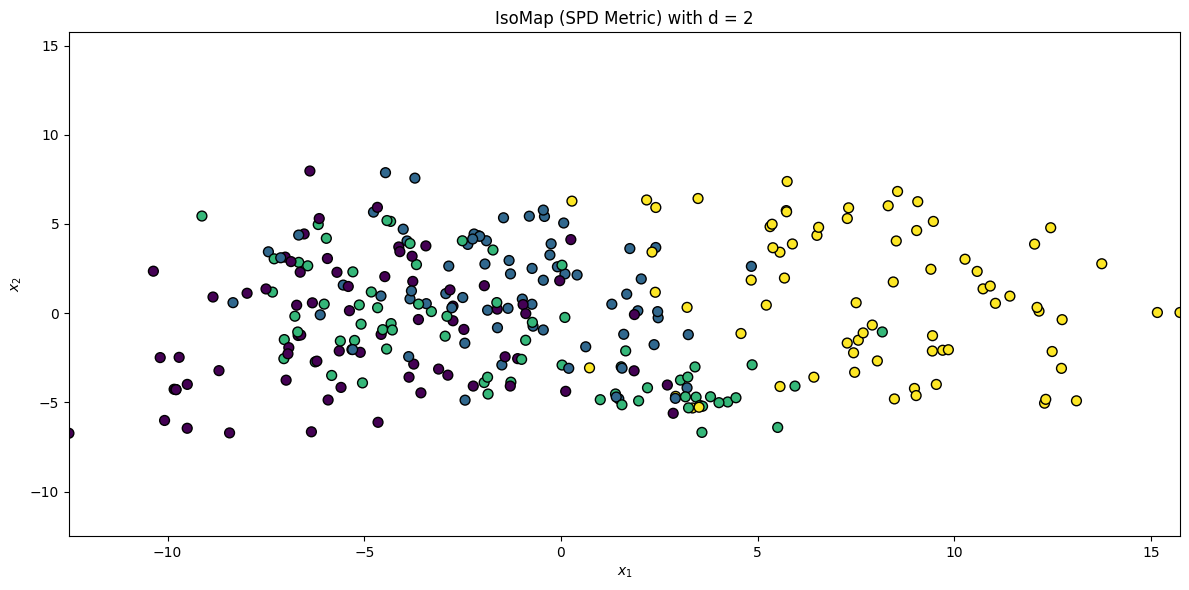

In [ ]:
# Plot the Low Dimensional Data
# This shows the result using IsoMap with SpdMetric.

oIsoMapDr = Isomap(n_neighbors = 3, n_components = d, metric = 'precomputed')

hF = plt.figure(figsize = (12, 6))

mZi = oIsoMapDr.fit_transform(mD)
hA = hF.add_subplot()
Plot2DScatter(mZi, hA, vY)
hA.set_title(f'IsoMap (SPD Metric) with d = {d}')

plt.tight_layout()
plt.show()



#### 9.2.1. Question

In the above the _IsoMap_ is used.  
If one would like to use SciKit Learn's _Spectral Embedding_ (See [`SpectralEmbedding`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html)) one need to supply _Affinity Matrix_ (See `affinity` parameter).  
Describe how would you generate such matrix based on `SpdMetric()`.

* <font color='brown'>(**#**)</font> SciKit Learn's _Spectral Embedding_ is equivalent to _Laplacian Eigenmaps_ on lecture notes.

#### 9.2.1. Solution

The basic stages are standard. We use `SpdMetric()` to define the nearest neighbors for graph connectivity, and make sure connectivity is symmetric.

We can convert the distance matrix into an affinity matrix by applying a "heat kernel" with the distance calculated by the `SpdMetric()` function:

$\text{affinity}(i, j) = \exp(-\frac{d(i, j)^2} {(2 \sigma^2)})= \exp(-\frac{\sum_{i=1}^{d}\log^{2}\left(\lambda_{i}\left(\boldsymbol{C}_{i}^{-1}\boldsymbol{C}_{j}\right)\right)} {(2 \sigma^2)})$

Applying this kernel on every entry in the distance matrix will convert it into a affinity matrix which values are between 0 and 1.

`SpdMetric()` is symmetric and we would only need to insert the above affinity for the connected pairs. Otherwise, the affinity is 0.

---

In [ ]:
#===========================Fill This===========================#
# 1. Use t-SNE and/or UMAP for Dimensionality Reduction.
# 2. On the output of (1) apply a classifier from SciKit Learn.
# 3. To measure the performance use `cross_val_predict()` with accuracy as score.
# 4. Display the confusion matrix of the result of the `cross_val_predict()`.
# !! Use the `SpdMetric()` for UMAP / t-SNE!
# !! This is a competition, optimize the hyper parameters of each step for best accuracy.
# !! No use of Neural Net based classifiers!
# !! If you use t-SNE, make sure to make it non random (See `init` and `random_state`).
# !! Pay attention to the run time limitation of the whole notebook.


#===============================================================#

In [ ]:
def draw_graphs(model, mZ_trans, results, title):
    fig, ax = plt.subplots(figsize = (18, 5))

    cm = confusion_matrix(y_true=vY, y_pred=results, labels=np.unique(vY))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lLabel)
    disp.plot(ax=ax)
    disp.ax_.set_title(f'{title} - Total Accuracy: {accuracy_score(y_true=vY, y_pred=results):0.2f}');
    plt.tight_layout()
    plt.show()

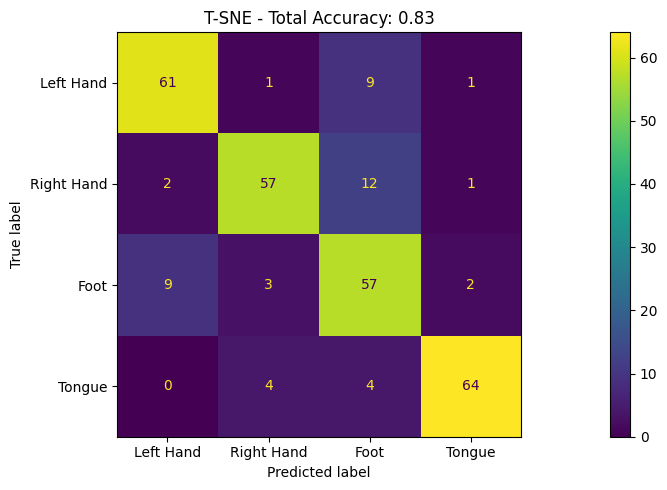

In [ ]:
perplexity = 42
tsne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', random_state=5, init='random')
mZ_trans = tsne.fit_transform(mD.copy())
svc = SVC(gamma=0.02)
results = cross_val_predict(svc ,mZ_trans,vY, cv=LeaveOneOut())
svc.fit(mZ_trans,vY)
draw_graphs(svc, mZ_trans, results, 'T-SNE')

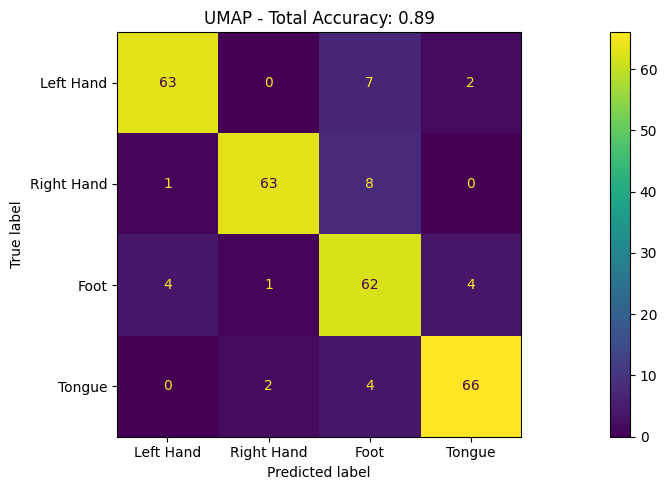

In [ ]:
umap = UMAP(n_components=27, n_neighbors=83, min_dist=0.9, densmap=False, metric='precomputed', random_state=5)
mZ_trans = umap.fit_transform(mD.copy())
svc = SVC(gamma=0.07)
results = cross_val_predict(svc ,mZ_trans,vY, cv=LeaveOneOut())
svc.fit(mZ_trans,vY)
draw_graphs(svc, mZ_trans, results, 'UMAP')

**These results were obtained using VS code. Running the same experiment in Google Colab produces different outcome**

#### 9.3.1. Question

In the above we had the whole data for the _dimensionality reduction_ step.  
Assume we use a method without _out of sample extension_.  
In the case above, how would you handle a new data point? Explain the pipeline.

#### 9.3.1. Solution

When Given a new sample $s_{0}$:
1. Compute the covariance matrix for the sample.
2. Apply the Feature Engineering, the end of this process should be a matrix with dimensions (22 x 22).
3. Define weights for the sample's $k$ nearest neighbors in the original data. For example in T-SNE these can be identified based on the conditional probabilities between $s_{0}$ and the original set of samples:
$$sp_{0,i}=\frac{exp(-d^{2}(s_{0},s_{i})/2\sigma_{i}^{2}}{\sum_{h\neq i}exp(-d^{2}(s_{i},s_{h})/2\sigma_{i}^{2}},i=1,2,\cdots N.$$
Use `SpdMetric()` as $d$.

Let $sp_{0,1}>sp_{0,2}>sp_{0,k}>sp_{0,N}$ denote the set of $N$ ordered probabilities, and $z^{′}_{1},z^{′}_{2},\cdots,z^{′}_{k}$
 denote the low-dimensional representations of the original data with the largest $k$ conditional probabilities, which will be labeled as the $k$ nearest neighbors of $s_{0}$.
 Then the low-dimensional representation of $s_{0}$ is given by:
 $$z_{0}=\sum_{i=1}^{k}w_{i}*z^{′}_{i}$$
 where $w_{i}=\frac{sp_{0,i}}{\sum_{i=1}^{k}sp_{0,i}}$ denotes the weight of $z^{′}_{i}$.

---